## Imports

In [1]:
%reload_ext autoreload
%autoreload 2

import os
import io
import pickle
import sys
import time
import json
import datetime

import boto3
import sagemaker
from sagemaker.tensorflow.estimator import TensorFlow
from sagemaker.model import Model
from sagemaker.predictor import Predictor
from sagemaker.processing import Processor, ProcessingInput, ProcessingOutput
from tqdm import tqdm
from sklearn.metrics import classification_report, PrecisionRecallDisplay
from sklearn.calibration import CalibrationDisplay, calibration_curve

import numpy as np
import polars as pl
from hydra import compose, initialize, core
from omegaconf import OmegaConf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Nopep8
import tensorflow as tf

import matplotlib.pyplot as plt
import optuna

from src.custom_utils import get_secret, get_db_url, StudyVisualizer

## Set Up

### Hydra

In [2]:
core.global_hydra.GlobalHydra.instance().clear()
initialize(version_base='1.2', config_path='../src/config', job_name='tf_keras_notebook')
config = OmegaConf.to_container(compose(config_name='main'), resolve=True)

### S3

In [3]:
s3 = boto3.client('s3')

train_val_test_path = {
    'train': f's3://{config["s3_bucket"]}/{config["s3_key"]}/input-data/train',
    'val': f's3://{config["s3_bucket"]}/{config["s3_key"]}/input-data/val',
    'test': f's3://{config["s3_bucket"]}/{config["s3_key"]}/input-data/test'
}
train_val_test_path 

{'train': 's3://yang-ml-sagemaker/income-classification/input-data/train',
 'val': 's3://yang-ml-sagemaker/income-classification/input-data/val',
 'test': 's3://yang-ml-sagemaker/income-classification/input-data/test'}

### SageMaker

In [ ]:
sagemaker_session = sagemaker.Session(default_bucket=config['s3_bucket'])
sm_boto3 = boto3.client('sagemaker')
ecr_boto3 = boto3.client('ecr')
role = sagemaker.get_execution_role()

### Database for Optuna

In [5]:
cf = boto3.client('cloudformation')
outputs = cf.describe_stacks(StackName=config['stack_name'])['Stacks'][0]['Outputs']

# 'Outputs' is a list of dictionaries, and we extract specific outputs based on their OutputKey property
host = [out['OutputValue'] for out in outputs if out['OutputKey'] == 'ClusterEndpoint'][0].split(':')[0]
db_name = [out['OutputValue'] for out in outputs if out['OutputKey'] == 'DatabaseName'][0]
secret_name = [out['OutputValue'] for out in outputs if out['OutputKey'] == 'DBSecretArn'][0].split(':')[-1].split('-')[0]

subnets = [out['OutputValue'] for out in outputs if out['OutputKey'] == 'PrivateSubnets'][0].split(',')
security_group_ids = [out['OutputValue'] for out in outputs if out['OutputKey'] == 'SageMakerSecurityGroup'][0].split(',')

## Processing Job

1. Data Loading: The script loads the training dataset from the URL specified in the configuration (`train_data_url`) and assigns appropriate column headers from the configuration. Similarly, the test dataset is read from its respective URL (`test_data_url`). It's important to note that the first row of this dataset is skipped due to being invalid. 

2. Ad-hoc Data Cleaning: Any trailing dots found in the target column of the test dataset are removed. This ensures consistency in the target labels across training and test datasets.

3. Validation Split: The training dataset undergoes a stratified shuffle split to carve out a validation set. This ensures that the validation dataset retains the same distribution of target labels as the original training dataset. The sizes and shapes of the training, validation, and test datasets are logged for verification.

4. Saving Processed Data: If not in test mode, the processed datasets (train, validation, and test) are saved as CSV files to the specified output location. This ensures that the cleaned and processed data is readily available for uploading.

### Docker Image for Preprocessing

We defined a bash script to assist in building and pushing custom images to ECR. The bash script needs three arguments:

* Docker image tag
* Mode ('preproccess' or 'serve')
* ECR repository name

In [ ]:
!cd {os.path.dirname(config['container_dir_path'])} && bash ./docker/build_and_push.sh process-latest preprocess {config['tf_keras']['ecr_repository']}

Construct the processing job image uri:

In [53]:
preprocess_images = !aws ecr list-images --repository-name {config['tf_keras']['ecr_repository']}
preprocess_images_str = '\n'.join(preprocess_images)
preprocess_images_str = json.loads(preprocess_images_str)

image_tag = preprocess_images_str['imageIds'][0]['imageTag']

preprocess_image_uri = f'{sagemaker_session.account_id()}.dkr.ecr.{sagemaker_session.boto_region_name}.amazonaws.com/{config["tf_keras"]["ecr_repository"]}:{image_tag}'

### Testing Processing Job Locally

In [54]:
# Clear tmp directory in case we run out of space
!sudo rm -rf /tmp/tmp*

In [ ]:
test_processor = Processor(
    image_uri=preprocess_image_uri,
    role=role,
    instance_type='local',
    instance_count=config['tf_keras']['instance_count'],
    base_job_name=config['tf_keras']['preprocess_base_job_name'],
    sagemaker_session=sagemaker_session,
    entrypoint=['python3', 'preprocess_entry.py']
)

test_processor.run(
    # The data sets are loaded from URLs directly into memory in the preprocessing script
    inputs=None,
    outputs=[
        ProcessingOutput(
            # The processing script writes train, validation, and test splits to these locations
            source=os.path.join(config['processing_job_output'], key),
            # Processing job will upload the preprocessed data to this S3 uri
            destination=train_val_test_path['train']
        ) for key in train_val_test_path
    ],
    # Run in test mode to not upload the preprocessed data to S3
    arguments=['--test_mode']
)

### Run Processing Job

In [ ]:
processor = Processor(
    image_uri=preprocess_image_uri,
    role=role,
    instance_type='local',
    instance_count=config['tf_keras']['instance_count'],
    base_job_name=config['tf_keras']['preprocess_base_job_name'],
    sagemaker_session=sagemaker_session,
    entrypoint=['python3', 'preprocess_entry.py']
)

processor.run(
    # The data sets are loaded from URLs directly into memory in the preprocessing script
    inputs=None,
    outputs=[
        ProcessingOutput(
            # The processing script writes train, validation, and test splits to these locations
            source=os.path.join(config['processing_job_output'], key),
            # Processing job will upload the preprocessed data to this S3 uri
            destination=train_val_test_path[key]
        ) for key in train_val_test_path
    ]
)

## Training Job

### Testing Training Job Locally

In [ ]:
test_study_name = 'test-study'

test_estimator = TensorFlow(
    entry_point=config['tf_keras']['entry_point'],
    source_dir=config['src_dir_path'],
    role=role,
    py_version=config['tf_keras']['py_version'],
    framework_version=config['tf_keras']['framework_version'],
    model_dir=config['model_dir'],
    output_path=config['output_path'],
    code_location=config['code_location'],
    instance_type='local',
    instance_count=config['tf_keras']['instance_count'],
    # Optuna
    subnets=subnets,
    security_group_ids=security_group_ids,
    hyperparameters={
        'host': host, 
        'db_name': db_name, 
        'study_name': test_study_name,
        'db_secret': secret_name, 
        'region_name': sagemaker_session._region_name,
        'n_trials': 2,
        'test_mode': 1
    }
)

test_estimator

In [61]:
# Clear tmp files
!sudo rm -rf /tmp/tmp*

In [ ]:
test_estimator.fit({key: train_val_test_path[key] for key in train_val_test_path if key != 'test'})

In [21]:
# Remove test study from Database
db_url = get_db_url(host=host, db_name=db_name, db_secret=secret_name, region_name=sagemaker_session._region_name)

optuna.study.delete_study(study_name=test_study_name, storage=db_url)

### Run Distributed Training with Optuna

In [19]:
tf_estimator = TensorFlow(
    # Entry point
    entry_point=config['tf_keras']['entry_point'],
    source_dir=config['src_dir_path'],
    py_version=config['tf_keras']['py_version'],
    framework_version=config['tf_keras']['framework_version'],
    # Sagemaker
    role=role,
    instance_type=config['tf_keras']['instance_type'],
    instance_count=config['tf_keras']['instance_count'],
    model_dir=config['model_dir'],
    output_path=config['output_path'],
    code_location=config['code_location'],
    volume_size=config['volume_size'],
    base_job_name=config['tf_keras']['train_base_job_name'],
    sagemaker_session=sagemaker_session,
    # # Spot traning (optional and can be commented out)
    # max_run=config['max_run'],
    # max_wait=config['max_run'], # Equal or greater than max_run
    # max_retry_attempts=config['max_retry_attempts'],
    # use_spot_instances=config['use_spot_instances'],
    # checkpoint_s3_uri=os.path.join(config['checkpoint_s3_uri'], 'tf_keras'),
    # Optuna
    subnets=subnets,
    security_group_ids=security_group_ids,
    hyperparameters={
        'host': host, 
        'db_name': db_name, 
        'db_secret': secret_name, 
        'region_name': sagemaker_session._region_name,
        'study_name': config['tf_keras']['study_name'],
        'n_trials': 10,
        'test_mode': 0
    }
)

tf_estimator

In [ ]:
tf_estimator.fit({key: train_val_test_path[key] for key in train_val_test_path if key != 'test'})

### Study Object

In [22]:
study = optuna.study.load_study(study_name=config['tf_keras']['study_name'], storage=db_url)
# Create a visualizer instance to visualize the study's optimization history
hpo_visualizer = StudyVisualizer(study=study)

Optimization history:

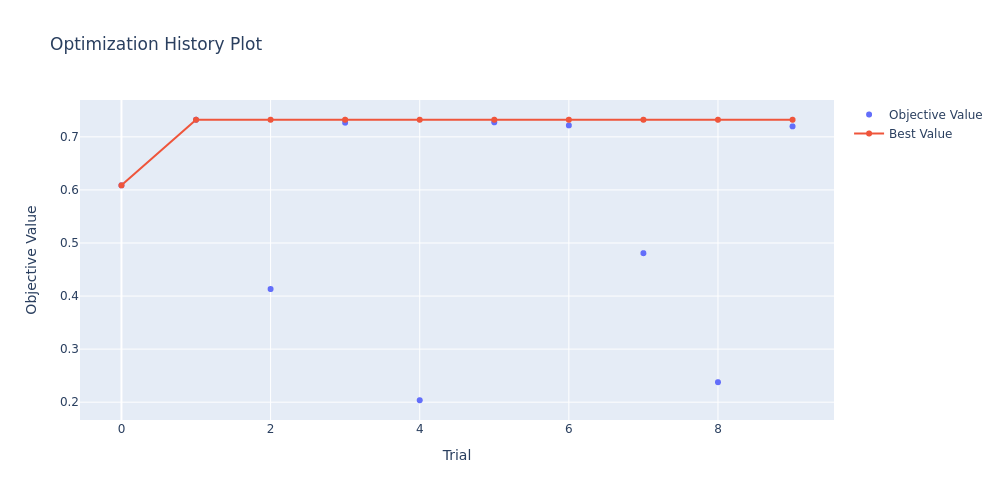

In [15]:
hpo_visualizer.plot_optimization_history(figsize=(1000, 500))

Parallel coordinate plots for transformer architectural hyperparameters:

* Dropout rates

* Embedding dimension

* Number of heads

* Number of layers per head

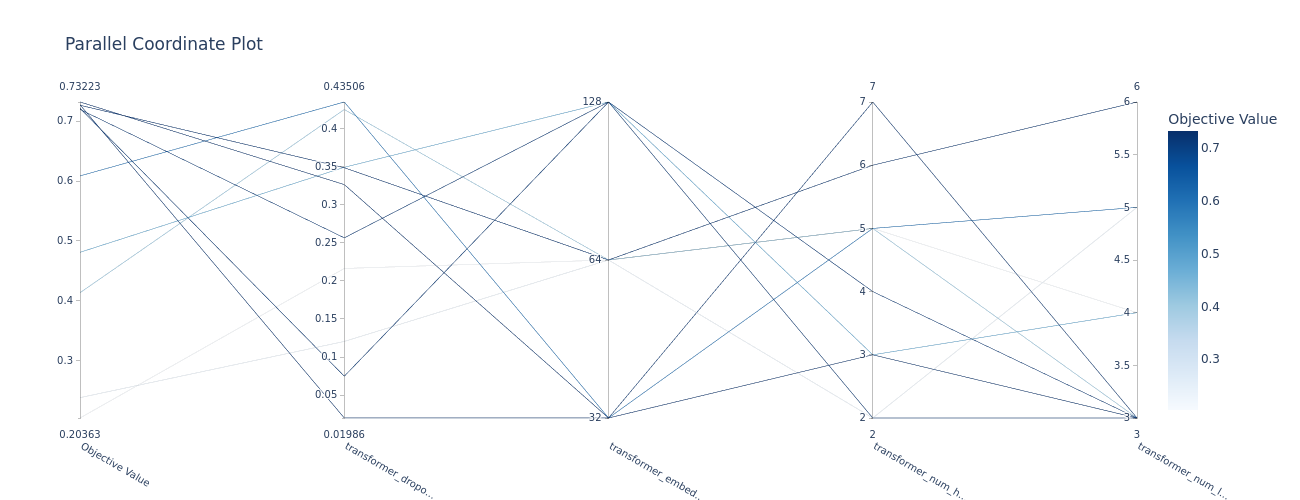

In [11]:
hpo_visualizer.plot_parallel_coordinate(
    figsize=(1300, 500), 
    params=[params for params in study.best_params.keys() if params.startswith('transformer')]
)

Paralell coordinates for adam optimizer hyperparamters:

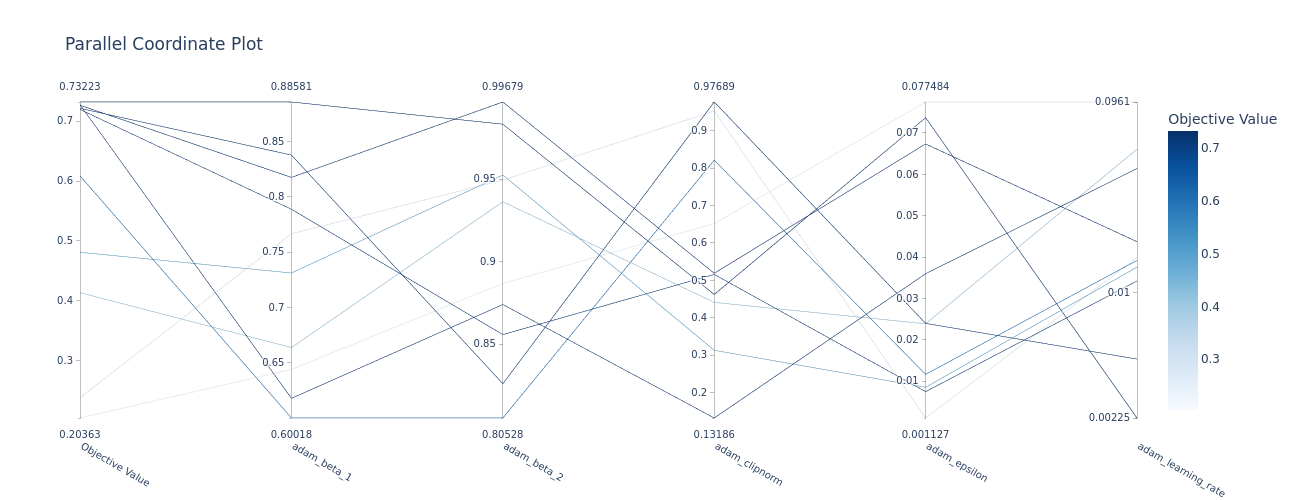

In [12]:
hpo_visualizer.plot_parallel_coordinate(
    figsize=(1300, 500), 
    params=[params for params in study.best_params.keys() if params.startswith('adam')]
)

Parallel coordinates for all other hyperparameters:

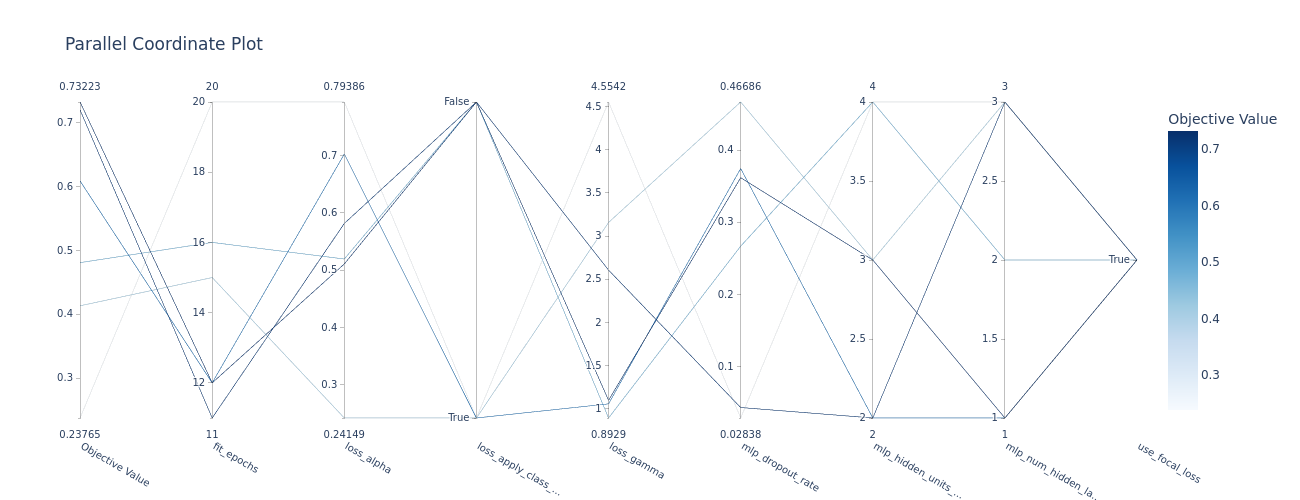

In [13]:
hpo_visualizer.plot_parallel_coordinate(
    figsize=(1300, 500), 
    params=[params for params in study.best_params.keys() if not params.startswith('transformer') and not params.startswith('adam')]
)

Hyperparameter importance:

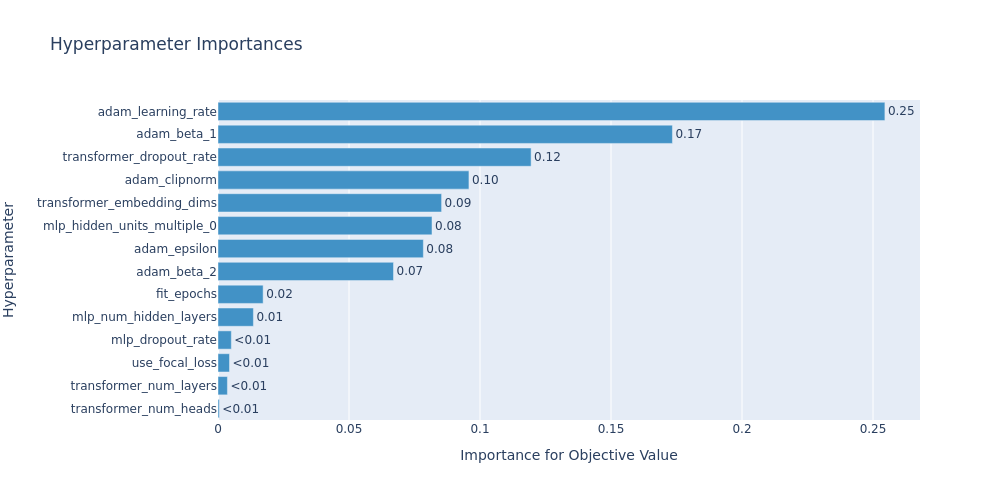

In [17]:
hpo_visualizer.plot_param_importances(figsize=(1000, 500))

### TensorBoard

We can also download and visualize training using Tensorboard:

In [ ]:
# S3 path of tensorboard logs
tensorboard_log_dir = f's3://{config["s3_bucket"]}/{config["s3_key"]}/tensorboard_logs/{study.best_trial.user_attrs["job_name"]}_{study.best_trial.number}'

# Download tensorboard logs from S3 to local
!aws s3 cp {tensorboard_log_dir} ./tensorboard_logs --recursive

# Start tensorboard
!tensorboard --logdir ./tensorboard_logs --host localhost --port 6006

In [6]:
# Remove downloaded logs
!rm -rf ./tensorboard_logs

## Inference on Test Set

In [7]:
test_data = pl.read_csv(f's3://{config["s3_bucket"]}/{config["s3_key"]}/input-data/test/test.csv', new_columns=config['csv_header'])
test_data.shape

(16279, 15)

In [9]:
# Split the test data into weight column, target, and features
weights = test_data['fnlwgt'].to_numpy()

target = test_data.with_columns(
    pl.when(pl.col("income_bracket") == " <=50K").then(0)
      .when(pl.col("income_bracket") == " >50K").then(1)
      .alias('encoded_income_bracket')
).select(['encoded_income_bracket']).to_numpy().flatten()

features = test_data.drop(['fnlwgt', 'income_bracket']).to_numpy()

# Feature matrix
features

array([[28, ' Local-gov', ' Assoc-acdm', ..., 0, 40, ' United-States'],
       [44, ' Private', ' Some-college', ..., 0, 40, ' United-States'],
       [18, ' ?', ' Some-college', ..., 0, 30, ' United-States'],
       ...,
       [38, ' Private', ' Bachelors', ..., 0, 50, ' United-States'],
       [44, ' Private', ' Bachelors', ..., 0, 40, ' United-States'],
       [35, ' Self-emp-inc', ' Bachelors', ..., 0, 60, ' United-States']],
      dtype=object)

### Deploy Best Model

We now build and push the serving image to ECR:

In [ ]:
!cd {os.path.dirname(config['container_dir_path'])} && bash ./docker/build_and_push.sh serve-latest serve {config['tf_keras']['ecr_repository']}

Construct the image uri:

In [17]:
ecr_images = !aws ecr list-images --repository-name {config['tf_keras']['ecr_repository']}
ecr_images_str = '\n'.join(ecr_images)
ecr_images_str = json.loads(ecr_images_str)
image_tag = ecr_images_str['imageIds'][0]['imageTag']

serving_image_uri = f"{sagemaker_session.account_id()}.dkr.ecr.{sagemaker_session.boto_region_name}.amazonaws.com/{config['tf_keras']['ecr_repository']}:{image_tag}"

Deploy the best model as an endpoint:

In [23]:
best_model_data = os.path.join(tf_estimator.output_path, study.best_trial.user_attrs['job_name'], 'output/model.tar.gz')

best_model = Model(
    image_uri=serving_image_uri,
    model_data=best_model_data,
    role=role,
    name=config['tf_keras']['model_name'],
    code_location=config['code_location'],
    sagemaker_session=sagemaker_session
)

best_model.deploy(
    initial_instance_count=config['tf_keras']['instance_count'],
    instance_type=config['tf_keras']['inference_instance_type'],
    endpoint_name=config['tf_keras']['endpoint_name'] + '-v1'
)

predictor = Predictor(
    endpoint_name=best_model.endpoint_name,
    sagemaker_session=sagemaker_session
)

----!

### Generate Predictions

In [24]:
# Define the batch size (number of samples to be sent for inference at once)
batch_size = 1000

# Generate predictions in batches
num_instances = features.shape[0]
num_batches = (num_instances + batch_size - 1) // batch_size

predicted_labels = []
for i in tqdm(range(num_batches)):
    start_idx = i * batch_size
    end_idx = min(start_idx + batch_size, num_instances)
    batch = features[start_idx:end_idx]
    
    # Bytes
    prediction_bytes = predictor.predict(str(batch.tolist()))
    # Deserialize byes to list of lists (one list per sample)
    prediction_lists = json.loads(prediction_bytes)
    
    # Append the predicted probabilities matrix to the container list
    predicted_labels.append(prediction_lists)

    # Wait 2 seconds before requesting inference predictions for the next batch
    time.sleep(2)

# Concatenate the predicted matrices from all batches
y_pred_positive = np.concatenate(predicted_labels, axis=0).flatten()

y_pred_positive

100%|██████████| 17/17 [00:37<00:00,  2.23s/it]


array([0.57062393, 0.64129066, 0.02203831, ..., 0.71357197, 0.15868251,
       0.73775578])

### Evaluations

In [25]:
print(classification_report(target, (y_pred_positive > 0.5).astype(np.int8)))

              precision    recall  f1-score   support

           0       0.91      0.86      0.89     12433
           1       0.62      0.74      0.67      3846

    accuracy                           0.83     16279
   macro avg       0.77      0.80      0.78     16279
weighted avg       0.84      0.83      0.83     16279



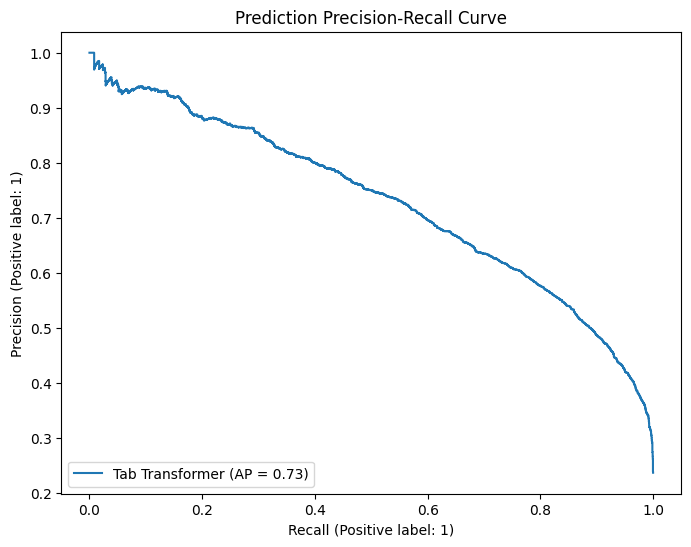

In [26]:
fig, ax = plt.subplots(figsize=(8, 6))
PrecisionRecallDisplay.from_predictions(target, y_pred_positive, name='Tab Transformer', ax=ax)
plt.title('Prediction Precision-Recall Curve')
plt.show();

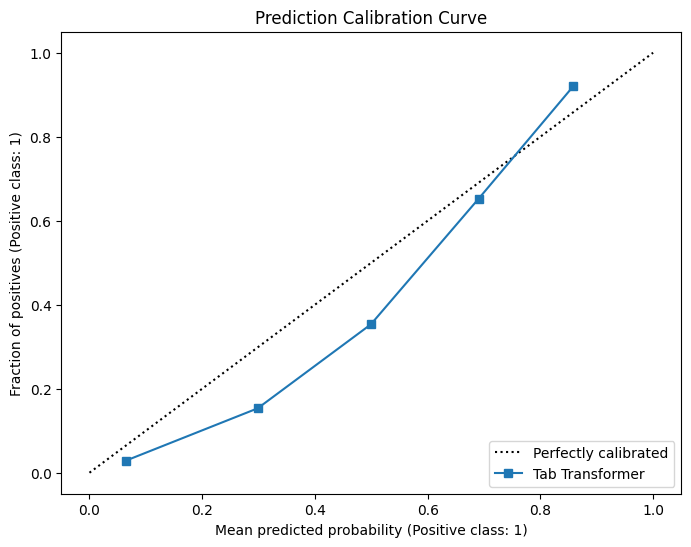

In [28]:
fig, ax = plt.subplots(figsize=(8, 6))
CalibrationDisplay.from_predictions(target, y_pred_positive, name='Tab Transformer', ax=ax)
plt.title('Prediction Calibration Curve')
plt.show();

Because the predictions (logits) are transformed with `tf.nn.sigmoid`, the classifier is well-calibrated. A well calibrated (binary) classifier should classify the samples such that among the samples to which it gave a predicted probability value close to, say, 0.8, approximately 80% actually belong to the positive class.

## Clean-up

In [29]:
ecr_boto3.batch_delete_image(
    repositoryName=config['tf_keras']['ecr_repository'],
    imageIds=[{'imageTag': image_tag}]
)
sm_boto3.delete_endpoint(EndpointName=predictor.endpoint_name)
sm_boto3.delete_endpoint_config(EndpointConfigName=predictor.endpoint_name)
sm_boto3.delete_model(ModelName=best_model.name)

{'ResponseMetadata': {'RequestId': '447b0a61-953e-4af8-ad54-dcc494b3ac1a',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '447b0a61-953e-4af8-ad54-dcc494b3ac1a',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Sat, 23 Sep 2023 06:25:36 GMT'},
  'RetryAttempts': 0}}

In [30]:
sm_boto3.close()